In [2]:
import sklearn
import glob
import pickle
import os
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D , BatchNormalization, Flatten, Input, AveragePooling2D, ZeroPadding2D, MaxPooling2D, GlobalMaxPooling2D,  Add, Activation
from keras.layers import RandomTranslation, RandomContrast, RandomZoom, RandomRotation
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint

# mount drive
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/ECSE_415/project'

# Show plots inline notebook
%matplotlib inline

Mounted at /content/drive


# Helper Methods

### Sliding Windows

In [4]:
def makeWindows(image_size, window_size, overlap=(0.5,0.5), x_range=(0, 1), y_range=(0, 1)):
    x_overlap, y_overlap = overlap
    window_w, window_h = window_size
    w, h = image_size
    
    windows = []
    y_step = int((1 - y_overlap) * window_h)
    for y in range(int(y_range[0] * h), int(y_range[1] * h), y_step):
        if y + window_h > int(y_range[1] * h) or window_w > w:
            break
        
        x_step = int((1 - x_overlap) * window_w)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + window_w, y + window_h))
            
    return np.array(windows)
    
def pyramidWindows(image_size, init_size=(64,64), overlap=(0.5,0.5), x_range=(0, 1), y_range=(0, 1), scale=1.5, steps=4):
    windows = None
    for i in range(0, steps):
        cur_scale = scale ** i
        window_size = (int(init_size[0] * cur_scale), int(init_size[1] * cur_scale))
        
        pyramid_windows = makeWindows(image_size, window_size, overlap=overlap, x_range=x_range, y_range=y_range)
        
        if windows is None:
            windows = pyramid_windows
        else:
            windows = np.vstack((windows, pyramid_windows))
        
    return windows


def slidingWindow(image_size, init_size=(64,64), x_overlap=0.5, y_step=0.05,
        x_range=(0, 1), y_range=(0, 1), scale=1.5, dims=False):
    windows = []
    y_count = 0
    h, w = image_size[1], image_size[0]
    for y in range(int(y_range[0] * h), int(y_range[1] * h), int(y_step * h)):
        y_count += 1
        win_width = int(init_size[0] + (scale * (y - (y_range[0] * h))))
        win_height = int(init_size[1] + (scale * (y - (y_range[0] * h))))
        if y + win_height > int(y_range[1] * h) or win_width > w:
            break
        x_step = int((1 - x_overlap) * win_width)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + win_width, y + win_height))

    if (dims):
        return windows, y_count
    return windows

### Intersection

In [5]:
def intersection(a, b):
  # determine the (x, y)-coordinates of the intersection rectangle
  xi = max(a[0], b[0])
  yi = max(a[1], b[1])
  xf = min(a[2], b[2])
  yf = min(a[3], b[3])
  # compute the area of intersection rectangle
  interArea = max(0, xf - xi + 1) * max(0, yf - yi + 1)

  return interArea

# Import Dataset


In [6]:
cmds = []

# McGill Image Dataset
# if not os.path.exists("dataset"):
#     cmds.append('wget -nc -O dataset.zip https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1')
#     cmds.append('unzip dataset.zip')
#     cmds.append('rm dataset.zip')

# Udacity Vehicles and Non-Vehicles Dataset
if not os.path.exists("vehicles"):
  cmds.append('wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip')
  cmds.append('unzip vehicles.zip')
  cmds.append('rm vehicles.zip')

if not os.path.exists("non-vehicles"):
  cmds.append('wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip')
  cmds.append('unzip non-vehicles.zip')
  cmds.append('rm non-vehicles.zip')

if os.path.exists("__MACOSX"):
  cmds.append('rm -r __MACOSX')

for cmd in cmds:
    os.system(cmd)

## Image Sequences

In [7]:
def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   False,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
      bbox[frame].append(line)
  
  for frame in bbox.keys():
    bbox[frame] = np.asarray(bbox[frame], np.int32)
    
  return bbox

In [8]:
dataset_path = f"{drive_path}/dataset"

bboxes = []
images = []
for seq_id in range(3):
    seq_bboxes_dict = parse(f'{dataset_path}/{seq_id:04d}.txt')

    for frame_id in range(len(seq_bboxes_dict.keys())):
        image = cv2.imread(f'{dataset_path}/{seq_id:04d}/{frame_id:06d}.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        images.append(image)
        bboxes.append(seq_bboxes_dict[frame_id])

    
images = np.array(images, dtype=np.float32) / 255.

In [30]:
# for 3-fold CV
sequences_bboxes = [bboxes[:154], bboxes[154:601], bboxes[601:]]
sequences = [images[:154, :, :, :], images[154:601, :, :, :], images[601:, :, :, :]]

In [10]:
from random import choice 

def getVehicles(images, boxes, resize_shape=(64,64)):
  vehicles = []

  for i, img in enumerate(images):
    img_boxes = boxes[i]
    for xi,yi,xf,yf in img_boxes: 
      vehicle = cv2.resize(img[yi:yf, xi:xf, :], resize_shape)
      vehicles.append(vehicle)
  
  return np.array(vehicles)
  
def getNonVehicles(images, boxes, max_intersection_thresh=0.4, shape=(64,64)):
  _ , h, w, c = images.shape

  # get sliding windows windows
  sliding_windows = slidingWindow((w, h),
                        init_size=shape, 
                        x_overlap=0.5, 
                        y_step=0.025, 
                        x_range=(0, 1), 
                        y_range=(0.4, 1), 
                        scale=1.3)

  non_vehicles = []
  for i, img in enumerate(images):
    img_boxes = boxes[i]
    for j in range(len(img_boxes)):
      max_intersection = 10
      counter = 0
      while(counter < 100 and max_intersection > max_intersection_thresh):
        counter += 1
        max_intersection = 0
        window = choice(sliding_windows)
        for box in img_boxes: 
          max_intersection = max(max_intersection, intersection(window, box))

      if (counter <= 100):
        xi,yi,xf,yf = window
        non_vehicle = cv2.resize(img[yi:yf, xi:xf, :], shape)
        non_vehicles.append(non_vehicle)

  return np.array(non_vehicles)

In [11]:
moreVehicles = getVehicles(images, bboxes)
print(moreVehicles.shape)
moreNonVehicles = getNonVehicles(images, bboxes)
print(moreNonVehicles.shape)

(4311, 64, 64, 3)
(4311, 64, 64, 3)


## Images for Training

Code to build and display training set taken from https://github.com/maxritter/SDC-Vehicle-Lane-Detection

In [12]:
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

print(len(cars))
print(len(non_cars))

# Read X Vector
X = []
for file in cars:    
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X.append(img)
for file in non_cars:    
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X.append(img)
X = np.array(X, dtype=np.float32) / 255.

# Add More Cars Vector
X = np.vstack((X, moreVehicles, moreNonVehicles))

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars)), np.ones(len(moreVehicles)), np.zeros(len(moreNonVehicles))])

# Split train and validation dataset with 10%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)

# Show messages
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

8792
8968
X_train shape: (23743, 64, 64, 3)
23743 train samples
2639 test samples


1.0 0.0


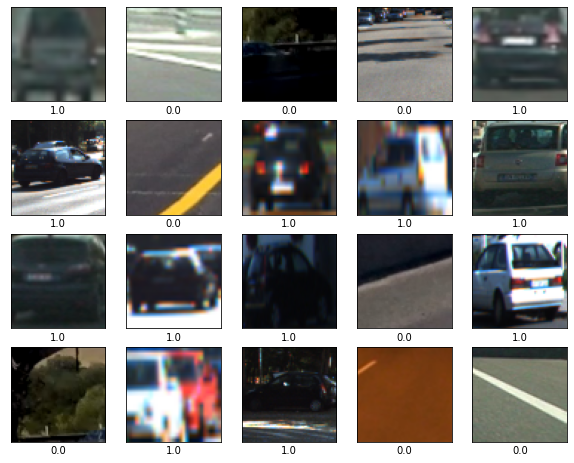

In [13]:
# show random images
print(np.max(X), np.min(X))

fig = plt.figure(figsize=(10, 8))
for i in range(0, 20):
    number = np.random.randint(0, len(X_train))
    axis = fig.add_subplot(4,5,i+1)
    axis.set_xlabel(Y_train[number])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    axis.imshow(X_train[number])
plt.show()

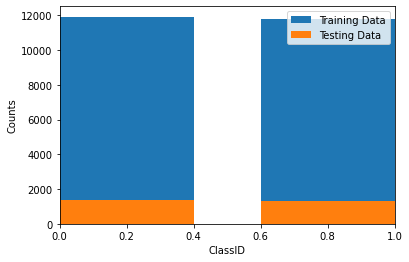

In [14]:
_, training_counts = np.unique(Y_train, return_counts = True)
_, test_counts = np.unique(Y_test, return_counts = True)
plt.bar( np.arange( 2 ), training_counts, label='Training Data')
plt.bar( np.arange( 2 ), test_counts, label='Testing Data')
plt.xlabel('ClassID')
plt.ylabel('Counts')
plt.xlim([0, 1])
plt.legend()
plt.show()

# Model Creation

In [15]:
def identity_block(X, f, filters):    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = filters, kernel_size = (f, f), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = filters, kernel_size = (f, f), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    
def convolutional_block(X, f, filters, s = 2):
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters, (f, f), strides = (s,s), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = filters, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1)(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = filters, kernel_size = (1, 1), strides = (s,s), padding = 'same',kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = -1)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [16]:
def ResNet18(input_shape=(64, 64, 3), classes=2):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2),  kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = Dropout(0.1)(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=64, s=1)
    X = identity_block(X, 3, 64)
    # X = Dropout(0.2)(X)

     # Stage 3
    X = convolutional_block(X, f=3, filters=128, s=2)
    X = identity_block(X, 3, 128)
    # X = Dropout(0.25)(X)

    # Stage 4
    X = convolutional_block(X, f=3, filters=256, s=2)
    X = identity_block(X, 3, 256)
    # X = Dropout(0.3)(X)

    # Stage 5
    X = convolutional_block(X, f=3, filters=512, s=2)
    X = identity_block(X, 3, 512)
    # X = Dropout(0.35)(X)

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dropout(0.6)(X)
    # X_output = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    # X_output = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    X_output = Dense(1, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    # letOutput = Dense(classes[1], activation='softmax', name="let", kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = [X_output], name='ResNet18')

    return model

model = ResNet18()
# model.summary()

In [17]:
# compile model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
              loss=["binary_crossentropy"], 
              metrics=['accuracy'])

# Training

In [ ]:
monitor = "val_accuracy" 

best_model_file = "model.h5"
best_model = ModelCheckpoint(best_model_file, monitor=monitor, verbose=2, save_best_only=True)

# fit model
history = model.fit( 
    X_train,
    Y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_test, Y_test),
    callbacks=[best_model]
)
    
# plot_model(history)

Epoch 1/20
371/371 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9193
Epoch 1: val_accuracy improved from -inf to 0.91171, saving model to model.h5
371/371 [==============================] - 25s 33ms/step - loss: 0.2276 - accuracy: 0.9193 - val_loss: 0.2344 - val_accuracy: 0.9117
Epoch 2/20
371/371 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9681
Epoch 2: val_accuracy improved from 0.91171 to 0.96173, saving model to model.h5
371/371 [==============================] - 11s 31ms/step - loss: 0.0907 - accuracy: 0.9681 - val_loss: 0.0994 - val_accuracy: 0.9617
Epoch 3/20
371/371 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9775
Epoch 3: val_accuracy improved from 0.96173 to 0.96628, saving model to model.h5
371/371 [==============================] - 12s 31ms/step - loss: 0.0673 - accuracy: 0.9775 - val_loss: 0.1234 - val_accuracy: 0.9663
Epoch 4/20
371/371 [==============================] - ETA: 0s - loss: 0.0

# Prediction

In [18]:
# Load the fine-tuned for the final network
model.load_weights(f'{drive_path}/models/model.h5')
print("Weights loaded!")

Weights loaded!


NN Prediction: NO CAR with value 0.005505354
Ground-truth: NO CAR with value 0.0


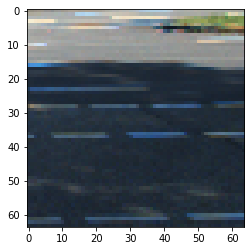

In [19]:
# Pick a random image from the test set
rand = np.random.randint(X_test.shape[0])
plt.imshow(X_test[rand])

# Predict the correct label
sample = np.reshape(X_test[rand], (1, 64,64,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
prediction = prediction[0][0]

# Check if the prediction is a car or a non-car
if prediction >= 0.5:
    print("NN Prediction: CAR with value " + str(prediction))
else:
    print("NN Prediction: NO CAR with value " + str(prediction))
    
# Compare with the ground-truth
truth = Y_test[rand]
if truth == 1:
    print("Ground-truth: CAR with value " + str(truth))
else:
    print("Ground-truth: NO CAR with value " + str(truth))

# Detection

## Select Random Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1242, 375)
1.0 0.0


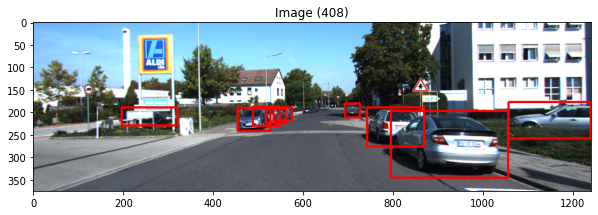

In [20]:
import cv2
from random import randint
import matplotlib.pyplot as plt

random_i = randint(0,len(images))

img_bboxes = bboxes[random_i]

img = images[random_i]
img_h, img_w, _ = img.shape
print((img_w, img_h))
print(np.max(img), np.min(img))

img_ground_truth = img.copy()
for xi, yi, xf, yf in img_bboxes: 
  img_ground_truth = cv2.rectangle(img_ground_truth, (xi, yi), (xf, yf), (255, 0, 0), 4)

# plot image
plt.figure(figsize=(10,10))
plt.title(f"Image ({random_i})")
plt.imshow(img_ground_truth)

plt.show()

## Bounding Box Grouping

In [21]:
from scipy.ndimage.measurements import label

# https://towardsdatascience.com/non-maxima-suppression-139f7e00f0b5#:~:text=The%20Non%2Dmaximum%20suppression%20(NMS,contains%20a%20different%20bounding%20box.&text=The%20overlap%20treshold%20determines%20the,boxes%20are%20allowed%20to%20have.
def nonMaxSuppression(boxes, overlapThresh=0.4, show=False):
  # if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [22]:
# https://nrsyed.com/2018/05/24/hog-based-svm-for-detecting-vehicles-in-a-video-part-6/
def heatmapMerge(boxes, img_size, threshold=2, min_bbox=(40,40), show=False):
    current_heatmap = np.zeros(img_size, dtype=np.float32)
    for (xi, yi, xf, yf) in boxes:
        current_heatmap[yi:yf, xi:xf] += 1

    # set treshold values to 0
    threshold_heatmap = current_heatmap.copy()
    threshold_heatmap[current_heatmap <= threshold] = 0

    # label images
    heatmap_labels = np.zeros((img_h, img_w))
    num_objects = label(threshold_heatmap, output=heatmap_labels)
    
    heatmap_boxes = []
    for obj in range(1, num_objects + 1):
        (Y_coords, X_coords) = np.nonzero(heatmap_labels == obj)
        xi, yi = min(X_coords), min(Y_coords)
        xf, yf = max(X_coords), max(Y_coords)

        # Only draw box if object is larger than min bbox size.
        if (xf - xi > min_bbox[0] and yf - yi > min_bbox[1]):
            heatmap_boxes.append((xi, yi, xf, yf))
            
    # show heatmap
    if show:
        plt.figure(figsize=(10,8))
        plt.subplot(211)
        plt.title("Heat Map")
        plt.imshow(current_heatmap, cmap="inferno")
        plt.subplot(212)
        plt.title("Thresholded Heat Map")
        plt.imshow(threshold_heatmap, cmap="inferno")
        plt.show()
        
    return heatmap_boxes

## Pipeline

In [23]:
def showBboxes(img, boxes, title="Bounding Boxes", color=(0,255,0), thickness=4):
  img_boxes = img.copy()
  for xi, yi, xf, yf in boxes: 
    img_boxes = cv2.rectangle(img_boxes, (xi, yi), (xf, yf), color, thickness)
    
  # boxes
  plt.figure(figsize = (15, 15)) 
  plt.title(title)
  plt.imshow(img_boxes)
  plt.show()

In [24]:
def detectVehicles(img, model, input_shape=(64,64),
                   merging_type="nms", nmsOverlapThresh=0.4, 
                   heatmapThresh=2, heatmapMinBbox=(40,40),
                   show=False):
  h, w, _ = img.shape
  
  # get sliding windows windows
  sliding_windows = slidingWindow((w, h),
                        init_size=(64,64), 
                        x_overlap=0.5, 
                        y_step=0.025, 
                        x_range=(0, 1), 
                        y_range=(0.4, 1), 
                        scale=1.3)
  
  # get sub-images from original image
  window_images = [ cv2.resize(img[yi:yf, xi:xf, :], (input_shape[1], input_shape[0])) for (xi, yi, xf, yf) in sliding_windows]
  window_images = np.array(window_images, dtype=np.float64)

  # predict using classifier
  predictions = model.predict(window_images, batch_size=64)

  # bounding boxes of windows classified as vehicles  
  boxes = [sliding_windows[ind] for ind in np.argwhere(predictions >= 0.9999)[:,0]]
  
  # show 
  if show:
    showBboxes(img, boxes, title="Predicted Bounding Boxes", color=(255, 0, 0), thickness=4)

  # merge bounding boxes
  if (merging_type == "nms"):
    nms_boxes = nonMaxSuppression(np.array(boxes), overlapThresh=nmsOverlapThresh)   

    if show:
      showBboxes(img, nms_boxes, title="NMS Bounding Boxes", color=(0, 255, 0), thickness=6)

    return nms_boxes
  elif (merging_type == "group"):
    grouped_boxes, _ = cv2.groupRectangles(boxes, 1) 

    if show:
      showBboxes(img, grouped_boxes, title="Grouped Rectangle Bounding Boxes", color=(0, 255, 0), thickness=6)

    return grouped_boxes
  elif (merging_type == "heatmap"):
    heatmap_boxes = heatmapMerge(boxes, (h,w), threshold=heatmapThresh, min_bbox=heatmapMinBbox, show=show) 

    if show:
      showBboxes(img, heatmap_boxes, title="Heatmap Bounding Boxes", color=(0, 255, 0), thickness=6)

    return heatmap_boxes
  
  
def multiImageDetection(images, clf, input_shape, orientations, pixels_per_cell, cells_per_block, merging_type="nms"):
  bboxes = []
  for image in images:
    img_bboxes = detectVehicles(image, clf, input_shape, orientations, pixels_per_cell, cells_per_block, 
                   merging_type=merging_type)
    bboxes.append(img_bboxes)
    
  return img_bboxes 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


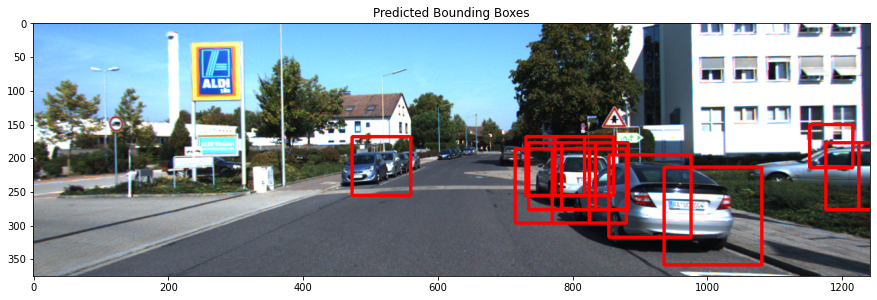

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


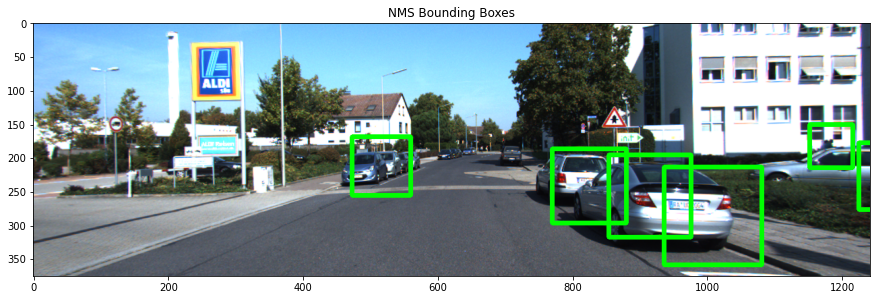

array([[ 936,  213, 1081,  358],
       [ 854,  195,  976,  317],
       [ 770,  186,  880,  296],
       [1225,  177, 1324,  276],
       [ 473,  168,  560,  255],
       [1152,  150, 1216,  214]])

In [25]:
detectVehicles(img, model, merging_type="nms", nmsOverlapThresh=0.3, heatmapThresh=3, show=True)

## Statistics

In [40]:
def iou(a, b):
  # determine the (x, y)-coordinates of the intersection rectangle
  xi = max(a[0], b[0])
  yi = max(a[1], b[1])
  xf = min(a[2], b[2])
  yf = min(a[3], b[3])
  # compute the area of intersection rectangle
  interArea = max(0, xf - xi + 1) * max(0, yf - yi + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  aArea = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
  bArea = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(aArea + bArea - interArea)
  # return the intersection over union value
  return iou

def computeMeanIoU(gt_bboxes, pred_bboxes):
  total_iou = 0
  for pred_box in pred_bboxes:
    max_iou = 0
    for gt_box in gt_bboxes:
      cur_iou = iou(pred_box, gt_box)
      if (max_iou < cur_iou):
        max_iou = cur_iou

    total_iou += max_iou
  
  if len(pred_bboxes) == 0:
    avg_iou = 0.5
  else:
    avg_iou = total_iou / len(pred_bboxes)
  
  return avg_iou

## 3-Fold Cross Validation

***Note: the format of the output was corrupted when downloading the file from google colab, however the results consistent between versions***


In [41]:
from statistics import mean, median
from tqdm.auto import tqdm

def crossValidation(validation_images, validation_bboxes, merging_type="nms"):
  ious = []
  for i, image in enumerate(tqdm(validation_images)):
    gt_bboxes = validation_bboxes[i]
    pred_bboxes = detectVehicles(image, model, merging_type=merging_type, nmsOverlapThresh=0.3, heatmapThresh=1, show=False)
    
    avg_iou = computeMeanIoU(gt_bboxes, pred_bboxes)
    
    ious.append(avg_iou)
  
  return mean(ious), median(ious)

def kFoldCrossValidation(seq_images, seq_bboxes, k=3, merging_type="nms"):
  for i in range(k):
    validation_images = seq_images[i]
    validation_bboxes = seq_bboxes[i]
    
    meanIoU, medianIoU = crossValidation(validation_images, validation_bboxes, merging_type=merging_type)
    
    print(f"Fold {i}:\n"
          f"\t Mean IoU: {meanIoU}\n"
          f"\t Median IoU: {medianIoU}")

### 3-Fold Cross Validation w/ NMS

In [42]:
kFoldCrossValidation(sequences, sequences_bboxes, merging_type="nms")

  0%|          | 0/154 [00:00<?, ?it/s]

Fold 0:
	 Mean IoU: 0.3701969427439073
	 Median IoU: 0.3761337262750424


  0%|          | 0/447 [00:00<?, ?it/s]

Fold 1:
	 Mean IoU: 0.4105239351275207
	 Median IoU: 0.40848288874123395


  0%|          | 0/170 [00:00<?, ?it/s]

Fold 2:
	 Mean IoU: 0.38385956218546674
	 Median IoU: 0.43637143158641545


### 3-Fold Cross Validation w/ Group Rectangles


In [43]:
kFoldCrossValidation(sequences, sequences_bboxes, merging_type="group")

  0%|          | 0/154 [00:00<?, ?it/s]

Fold 0:
	 Mean IoU: 0.3890209061950454
	 Median IoU: 0.3891723533154123


  0%|          | 0/447 [00:00<?, ?it/s]

Fold 1:
	 Mean IoU: 0.41790737608666434
	 Median IoU: 0.4352642510962382


  0%|          | 0/170 [00:00<?, ?it/s]

Fold 2:
	 Mean IoU: 0.441003294588444
	 Median IoU: 0.5


### 3-Fold Cross Validation w/ Heatmaps

In [44]:
kFoldCrossValidation(sequences, sequences_bboxes, merging_type="heatmap")

  0%|          | 0/154 [00:00<?, ?it/s]

Fold 0:
	 Mean IoU: 0.423811536053038
	 Median IoU: 0.4495022741329099


  0%|          | 0/447 [00:00<?, ?it/s]

Fold 1:
	 Mean IoU: 0.4294756923848184
	 Median IoU: 0.45215005568684974


  0%|          | 0/170 [00:00<?, ?it/s]

Fold 2:
	 Mean IoU: 0.457241395433569
	 Median IoU: 0.5
